# Student Performance Analysis Project
This notebook analyzes factors influencing student performance in Portuguese and Mathematics using data from two Portuguese schools.

### 1. Import Required Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### 2. Data Loading and Initial Exploration

In this section, we load and combine the mathematics and Portuguese datasets into a single dataset, explore its structure, and evaluate its quality. These steps are essential for understanding the data and preparing it for further analysis.

#### Steps:
- Load the datasets for Math and Portuguese courses.
- Add a `subject` column to differentiate between the two datasets.
- Combine the datasets using `pd.concat`.
- Check for missing values and basic information to ensure data quality.
- Compute percentiles for the target variable `G3` to understand its distribution.
- Explore correlations between grades (`G1`, `G2`, `G3`) to identify relationships.


In [24]:
math_df = pd.read_csv('student-mat.csv', sep=';')
por_df = pd.read_csv('student-por.csv', sep=';')

In [26]:
math_df['subject'] = 'math'
por_df['subject'] = 'portuguese'

In [28]:
df = pd.concat([math_df, por_df], axis=0, ignore_index=True)

In [30]:
print("Dataset Shape:", df.shape)
print("\nBasic Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (1044, 34)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  paid        1044 non-null   object
 18  activities  1044 non-null   object
 19  nu

In [32]:
print("First few rows of the dataset:")
display(df.head())

First few rows of the dataset:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [34]:
# Percentiles
grades_percentile = np.percentile(df['G3'], [25, 50, 75])
print(f"25th, 50th, 75th Percentiles for Final Grade: {grades_percentile}")

# Correlation Matrix 
correlation_matrix = np.corrcoef(df[['G1', 'G2', 'G3']].T)
print("\nCorrelation Matrix:")
print(correlation_matrix)

25th, 50th, 75th Percentiles for Final Grade: [10. 11. 14.]

Correlation Matrix:
[[1.         0.85873875 0.80914172]
 [0.85873875 1.         0.91074316]
 [0.80914172 0.91074316 1.        ]]


### 3. Data Preprocessing

In this section, we prepare the data for analysis by:
- Selecting relevant features based on the research question.
- Encoding categorical variables for compatibility with machine learning algorithms.
- Exploring relationships between predictors and `G3` through summary statistics.

We focus on 18 key predictors covering student demographics, academic history, and social factors. For categorical features, we calculate the mean `G3` to understand their impact on final grades.


In [37]:
features = ['age', 'sex', 'studytime', 'Medu', 'Fedu', 'Pstatus', 'famrel', 'schoolsup', 'famsup',
            'internet','guardian', 'goout', 'G1', 'G2', 'failures' ,'higher','paid','activities','G3', 'subject']

df_cleaned = df[features].copy()

In [39]:
le = LabelEncoder()

categorical_cols = ['sex', 'Pstatus', 'schoolsup', 'famsup', 'internet', 
                    'guardian', 'higher', 'paid', 'activities', 'subject']

for col in categorical_cols:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

# Display summary statistics for the cleaned DataFrame
print("Summary statistics of cleaned data:")
display(df_cleaned.describe())

Summary statistics of cleaned data:


,age,sex,studytime,Medu,Fedu,Pstatus,famrel,schoolsup,famsup,internet,guardian,goout,G1,G2,failures,higher,paid,activities,G3,subject
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,0.433908,1.970307,2.603448,2.387931,0.884100,3.935824,0.113985,0.613027,0.792146,0.837165,3.156130,11.213602,11.246169,0.264368,0.914751,0.210728,0.494253,11.341954,0.621648
std,1.239975,0.495850,0.834353,1.124907,1.099938,0.320259,0.933401,0.317945,0.487291,0.405967,0.525767,1.152575,2.983394,3.285071,0.656142,0.279386,0.408021,0.500207,3.864796,0.485209
min,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,1.000000,2.000000,1.000000,1.000000,4.000000,0.000000,0.000000,1.000000,1.000000,2.000000,9.000000,9.000000,0.000000,1.000000,0.000000,0.000000,10.000000,0.000000
50%,17.000000,0.000000,2.000000,3.000000,2.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,3.000000,11.000000,11.000000,0.000000,1.000000,0.000000,0.000000,11.000000,1.000000
75%,18.000000,1.000000,2.000000,4.000000,3.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,4.000000,13.000000,13.000000,0.000000,1.000000,0.000000,1.000000,14.000000,1.000000
max,22.000000,1.000000,4.000000,4.000000,4.000000,1.000000,5.000000,1.000000,1.000000,1.000000,2.000000,5.000000,19.000000,19.000000,3.000000,1.000000,1.000000,1.000000,20.000000,1.000000


In [41]:
df_cleaned[['sex', 'G3']].groupby('sex', as_index=False).mean()

,sex,G3
0,0,11.448393
1,1,11.203091


In [43]:
df_cleaned[['age', 'G3']].groupby('age', as_index=False).mean()

,age,G3
0,15,11.747423
1,16,11.637011
2,17,11.563177
3,18,10.950450
4,19,8.964286
5,20,12.666667
6,21,9.666667
7,22,6.500000


In [45]:
df_cleaned[['goout', 'G3']].groupby('goout', as_index=False).mean()

,goout,G3
0,1,10.450704
1,2,12.056452
2,3,11.689552
3,4,11.092511
4,5,10.276074


In [47]:
df_cleaned[['guardian', 'G3']].groupby('guardian', as_index=False).mean()

,guardian,G3
0,0,11.641975
1,1,11.366758
2,2,10.095890


In [49]:
df_cleaned[['paid', 'G3']].groupby('paid', as_index=False).mean()

,paid,G3
0,0,11.440534
1,1,10.972727


### 4. Exploratory Data Analysis (EDA)

In this section, we use visualizations to explore the relationships between various features and final grades (`G3`). The aim is to identify patterns and insights that align with our research question:  
*"What factors most influence student performance, and can we accurately predict students' final grades?"*

#### Key Visualizations:
1. **Correlations:** A heatmap to identify the strength of relationships between numerical variables.
2. **Distributions:** Histograms to visualize the spread of final grades (`G3`) by subject.
3. **Academic Predictors:** Boxplots to analyze the impact of study time, failures, and grade progression (`G1`, `G2`, `G3`).
4. **Social and Family Factors:** Bar plots to examine the role of internet access, educational support, and family relationships.
5. **Parental Education:** A heatmap to explore the interaction between mother and father education levels (`Medu`, `Fedu`).

These visualizations will help us identify significant predictors and patterns in student performance.


In [56]:
# Create correlation matrix
plt.figure(figsize=(10, 8))  
sns.heatmap(df_cleaned.corr(),annot=True cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3413715973.py, line 3)

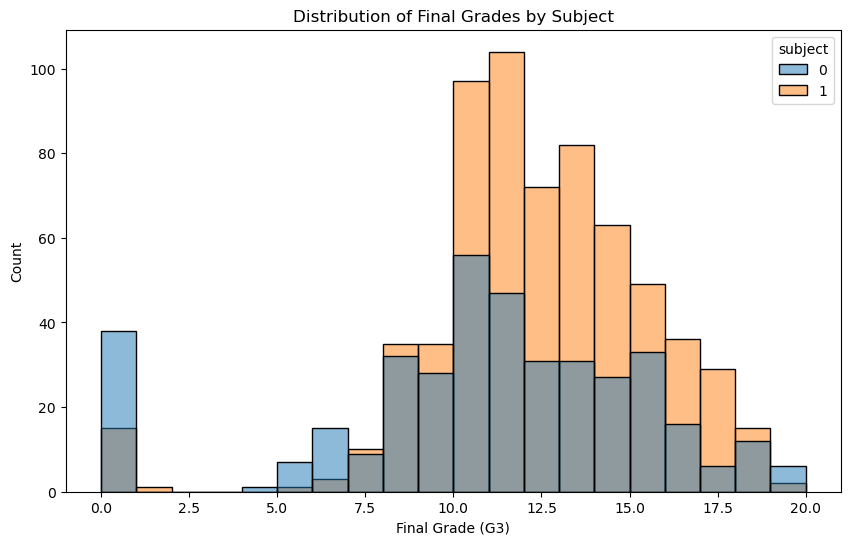

In [22]:
# Distribution of final grades by subject
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='G3', hue='subject', bins=20)
plt.title('Distribution of Final Grades by Subject')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Final Grade (G3)')

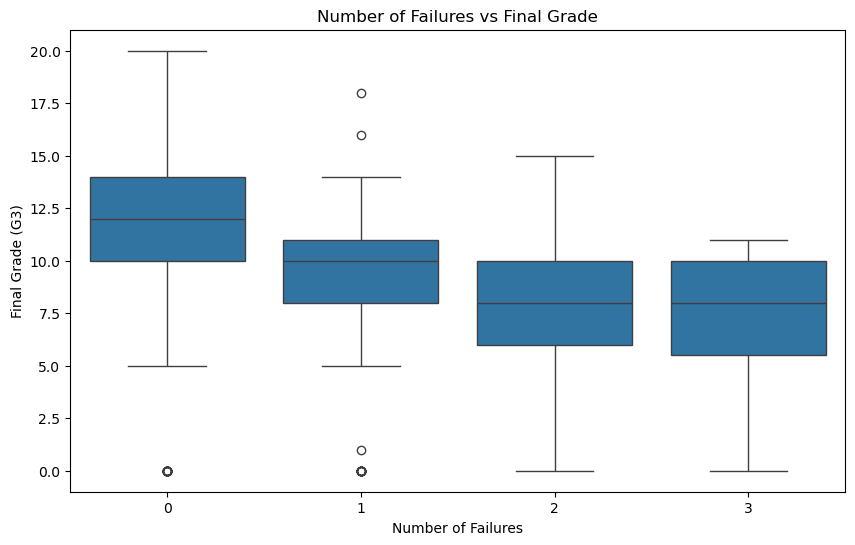

In [23]:
# Failures vs Final Grade
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='failures', y='G3')
plt.title('Number of Failures vs Final Grade')
plt.xlabel('Number of Failures')
plt.ylabel('Final Grade (G3)')

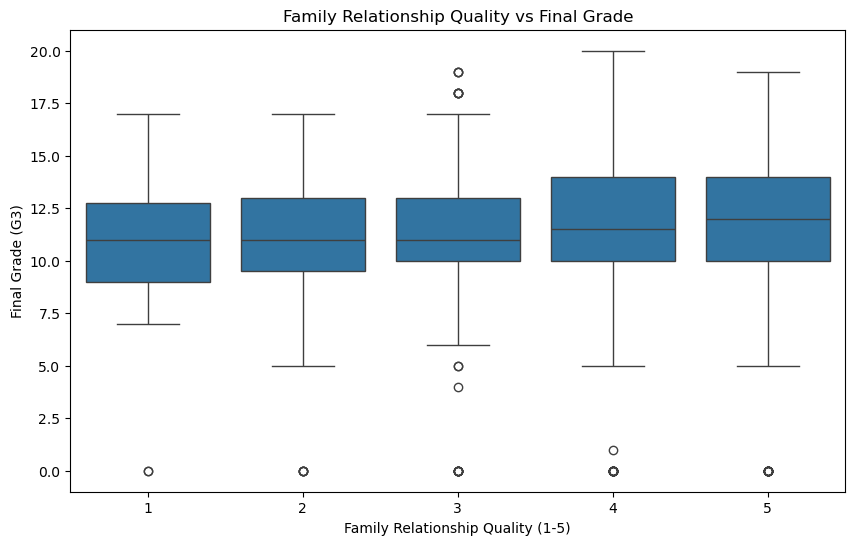

In [24]:
# Family Relationship Quality vs Final Grade (G3)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='famrel', y='G3')
plt.title('Family Relationship Quality vs Final Grade')
plt.xlabel('Family Relationship Quality (1-5)')
plt.ylabel('Final Grade (G3)')
plt.show()

Text(0, 0.5, 'Final Grade (G3)')

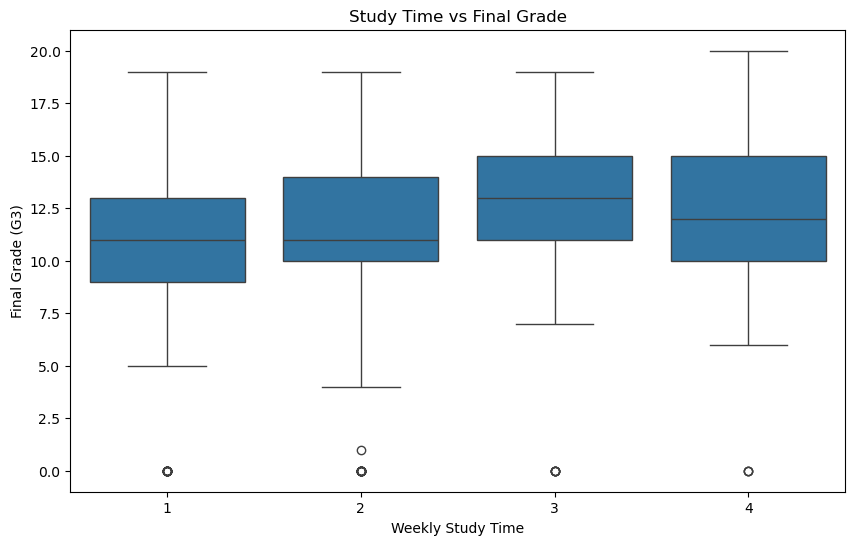

In [25]:
# Study time vs Final Grade
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned, x='studytime', y='G3')
plt.title('Study Time vs Final Grade')
plt.xlabel('Weekly Study Time')
plt.ylabel('Final Grade (G3)')

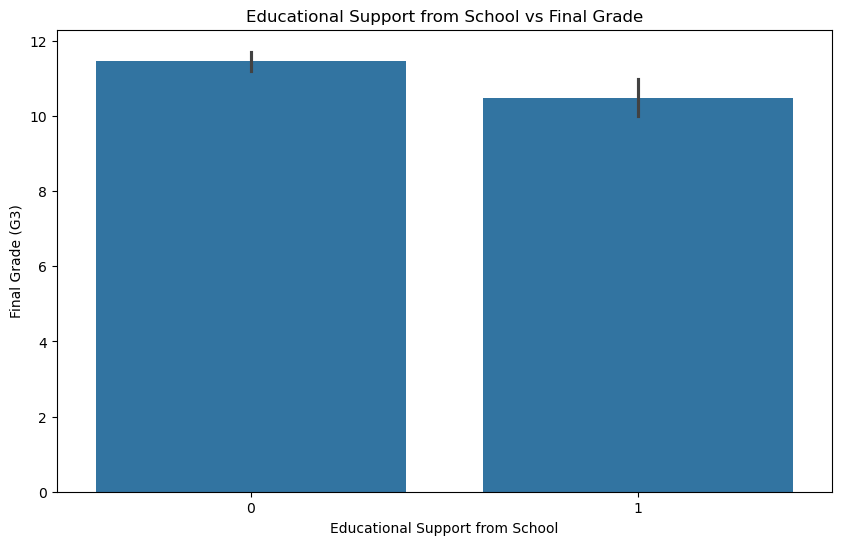

In [26]:
# Educational Support vs Final Grade (G3)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x='schoolsup', y='G3')
plt.title('Educational Support from School vs Final Grade')
plt.xlabel('Educational Support from School')
plt.ylabel('Final Grade (G3)')
plt.show()

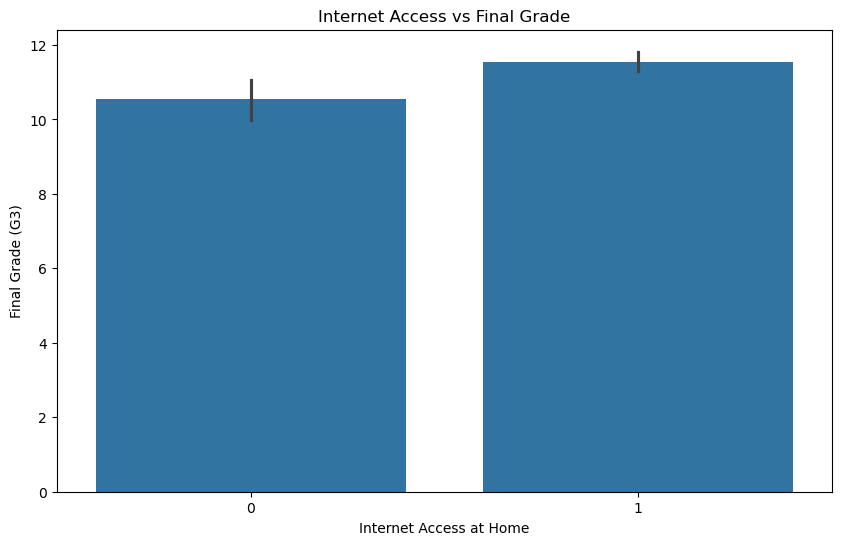

In [27]:
# Internet Access vs Final Grade (G3)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cleaned, x='internet', y='G3')
plt.title('Internet Access vs Final Grade')
plt.xlabel('Internet Access at Home')
plt.ylabel('Final Grade (G3)')
plt.show()

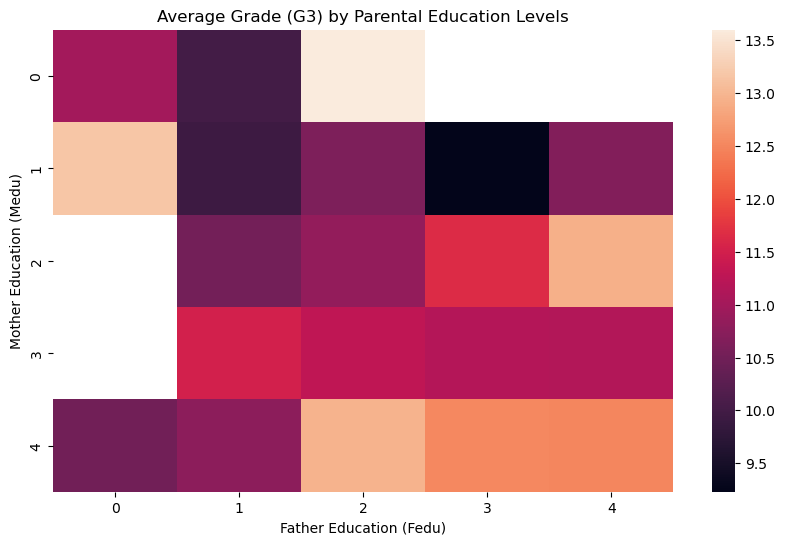

In [28]:
# Interaction between Medu and Fedu
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df_cleaned['Medu'], df_cleaned['Fedu'], values=df_cleaned['G3'], aggfunc='mean'))
plt.title('Average Grade (G3) by Parental Education Levels')
plt.xlabel('Father Education (Fedu)')
plt.ylabel('Mother Education (Medu)')
plt.show()

<Figure size 1000x600 with 0 Axes>

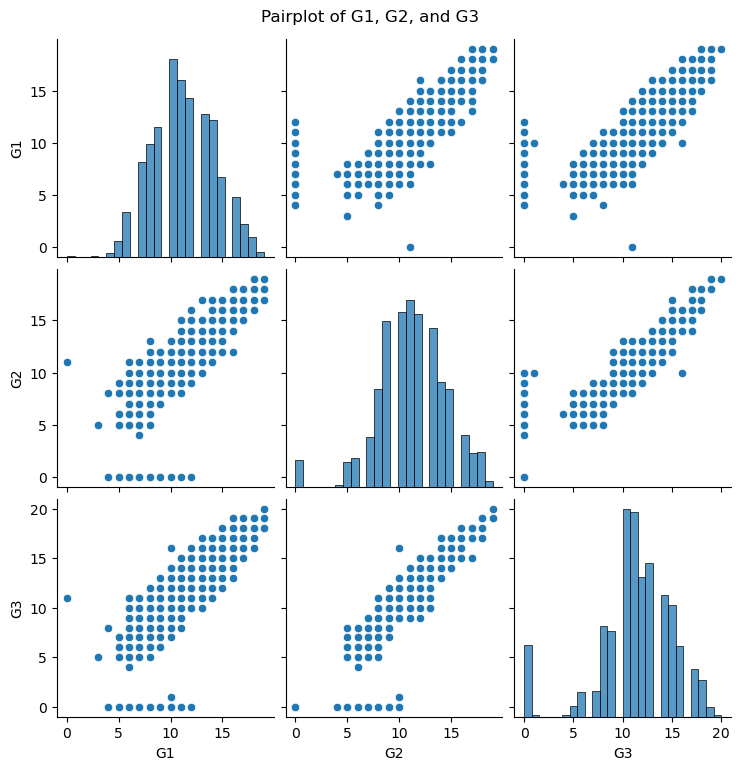

In [29]:
# Relationship between G1, G2, and G3
plt.figure(figsize=(10, 6))
sns.pairplot(df_cleaned[['G1', 'G2', 'G3']])
plt.suptitle('Pairplot of G1, G2, and G3',  size=12, y=1.02)
plt.show()

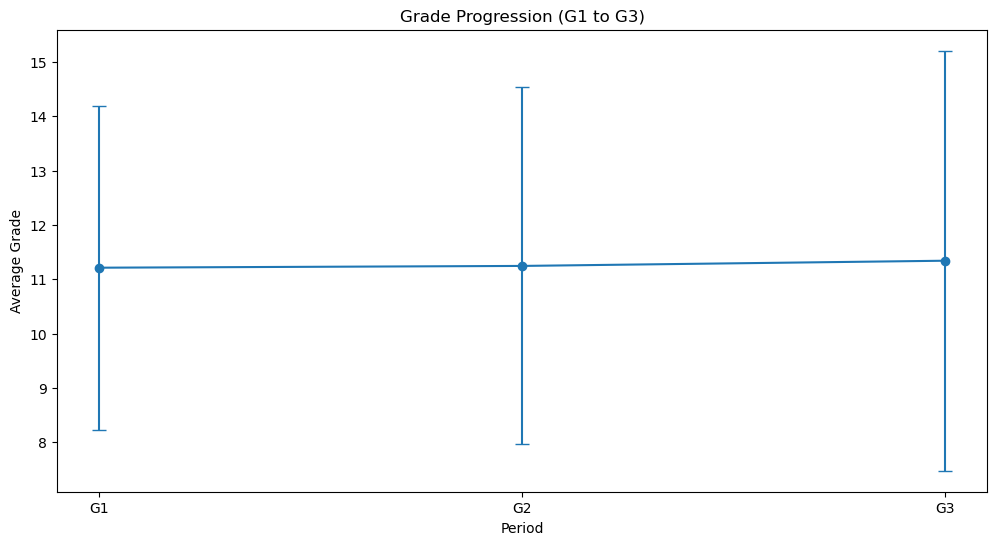

In [30]:
plt.figure(figsize=(12, 6))
grades_mean = df_cleaned[['G1', 'G2', 'G3']].mean()
grades_std = df_cleaned[['G1', 'G2', 'G3']].std()

plt.errorbar(range(1, 4), grades_mean, yerr=grades_std, fmt='o-', capsize=5)
plt.title('Grade Progression (G1 to G3)')
plt.xlabel('Period')
plt.ylabel('Average Grade')
plt.xticks([1, 2, 3], ['G1', 'G2', 'G3'])
plt.show()

### 5. Feature Engineering and Model Preparation
In this section, we prepare our data for modeling by:
- Separating features and target variable
- Splitting data into training and testing sets
- Scaling numerical features to ensure all variables are on the same scale

In [32]:
# Separate features and target
X = df_cleaned.drop(['G3'], axis=1)
y = df_cleaned['G3']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['age', 'studytime', 'Medu', 'Fedu', 'famrel', 'goout', 'G1', 'G2', 'failures']


X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Summary statistics of scaled data:")
display(X_train_scaled[numerical_cols].describe())

Summary statistics of scaled data:


,age,studytime,Medu,Fedu,famrel,goout,G1,G2,failures
count,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02,8.350000e+02
mean,1.397684e-15,3.616535e-17,-1.786994e-16,-1.021139e-16,2.255016e-16,-1.648714e-16,2.478390e-16,-9.998655e-17,-1.042413e-16
std,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00,1.000599e+00
min,-1.365245e+00,-1.165197e+00,-2.348225e+00,-2.195343e+00,-3.063110e+00,-1.855908e+00,-2.785118e+00,-3.453494e+00,-4.083496e-01
25%,-5.613102e-01,-1.165197e+00,-5.510042e-01,-3.731646e-01,1.049703e-01,-9.925748e-01,-7.555265e-01,-6.960558e-01,-4.083496e-01
50%,2.426246e-01,3.006037e-02,3.476061e-01,-3.731646e-01,1.049703e-01,-1.292415e-01,-7.899607e-02,-8.329187e-02,-4.083496e-01
75%,1.046559e+00,3.006037e-02,1.246216e+00,5.379244e-01,1.160997e+00,7.340918e-01,5.975344e-01,5.294721e-01,-4.083496e-01
max,4.262299e+00,2.420575e+00,1.246216e+00,1.449013e+00,1.160997e+00,1.597425e+00,2.627126e+00,2.367764e+00,4.117826e+00


### 6. Model Training and Evaluation

We train two models to predict final grades (`G3`):

1. **Linear Regression:** A simple, interpretable baseline model.
2. **Random Forest:** A more complex ensemble model capable of capturing non-linear relationships and feature interactions.

#### Evaluation Metrics:
- **Mean Absolute Error (MAE):** Measures the average absolute error in predictions.
- **Root Mean Square Error (RMSE):** Penalizes larger errors, offering a stricter evaluation than MAE.
- **R² Score:** Indicates how well the model explains the variance in the target variable.

By comparing these metrics, we assess the relative performance of each model and their ability to accurately predict student grades.


In [34]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
 
# Make predictions
lr_pred = lr_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)


# Calculate metrics for Linear Regression
mae_lr = mean_absolute_error(y_test, lr_pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))
r2_lr = r2_score(y_test, lr_pred)

print("Model Performance Metrics:")
print("\nLinear Regression:")
print(f"Mean Absolute Error: {mae_lr:.4f}")
print(f"Root Mean Squared Error: {rmse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

# Calculate metrics for Random Forest
mae_rf = mean_absolute_error(y_test, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
r2_rf = r2_score(y_test, rf_pred)

print("\nRandom Forest:")
print(f"Mean Absolute Error: {mae_rf:.4f}")
print(f"Root Mean Squared Error: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")


Model Performance Metrics:

Linear Regression:
Mean Absolute Error: 0.9396
Root Mean Squared Error: 1.5291
R² Score: 0.8465

Random Forest:
Mean Absolute Error: 0.9662
Root Mean Squared Error: 1.5180
R² Score: 0.8487


## 7. Results Visualization
Finally, we visualize our results to understand:
- Feature importance in predicting final grades
- How well our predictions match actual grades
- The relative performance of different models

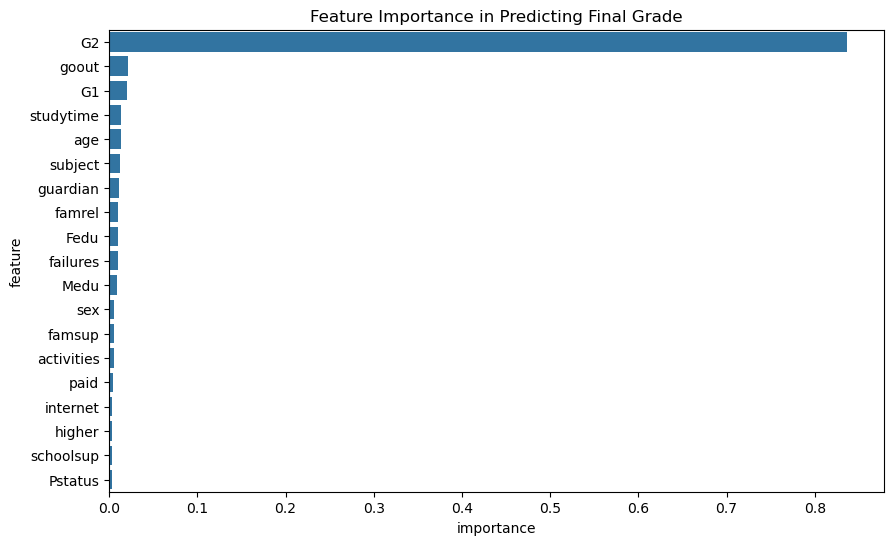

In [36]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Final Grade')
plt.show()

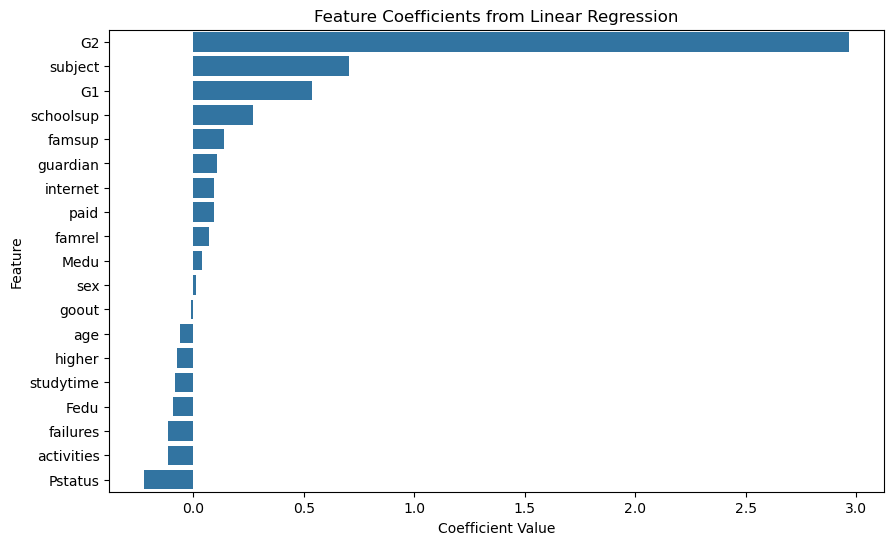

In [37]:
# Coefficients from Linear Regression
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients, x='Coefficient', y='Feature')
plt.title('Feature Coefficients from Linear Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

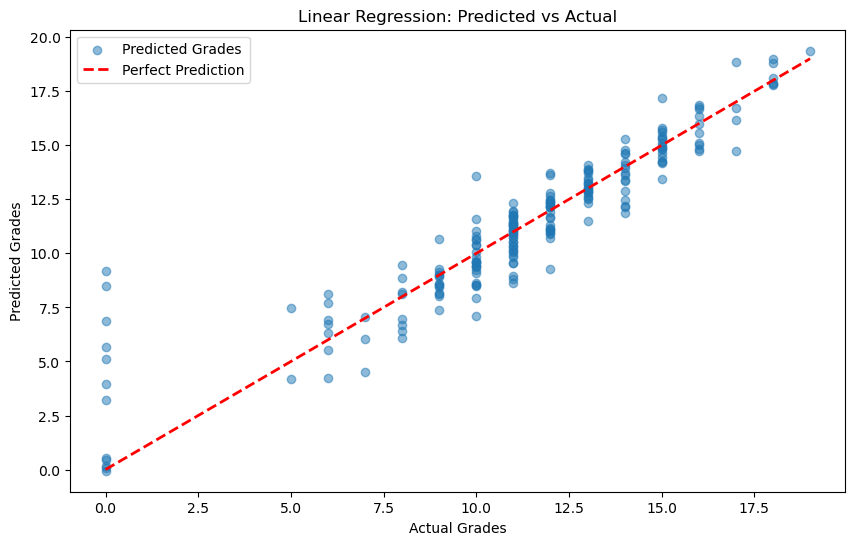

In [38]:
# Linear Regression: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pred, alpha=0.5, label='Predicted Grades')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Linear Regression: Predicted vs Actual')
plt.legend()
plt.show()

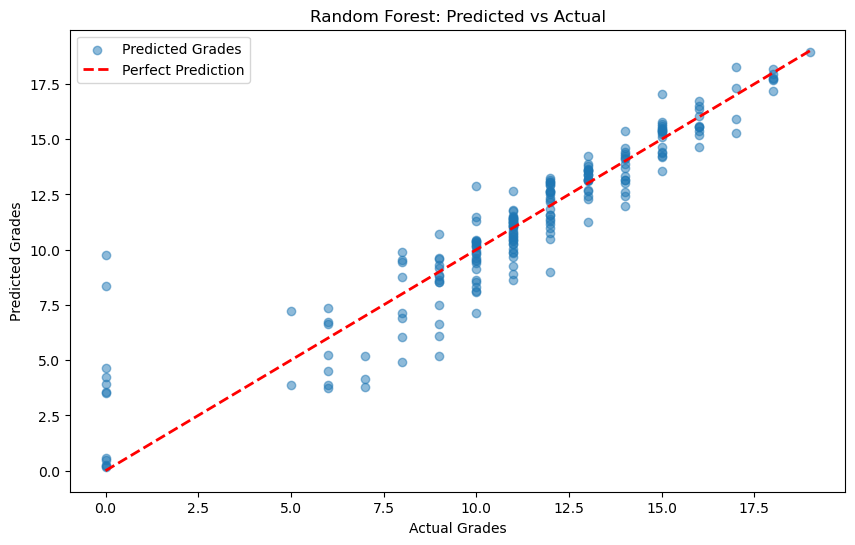

In [39]:
# Random Forest: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, label='Predicted Grades')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Grades')
plt.ylabel('Predicted Grades')
plt.title('Random Forest: Predicted vs Actual')
plt.legend()
plt.show()

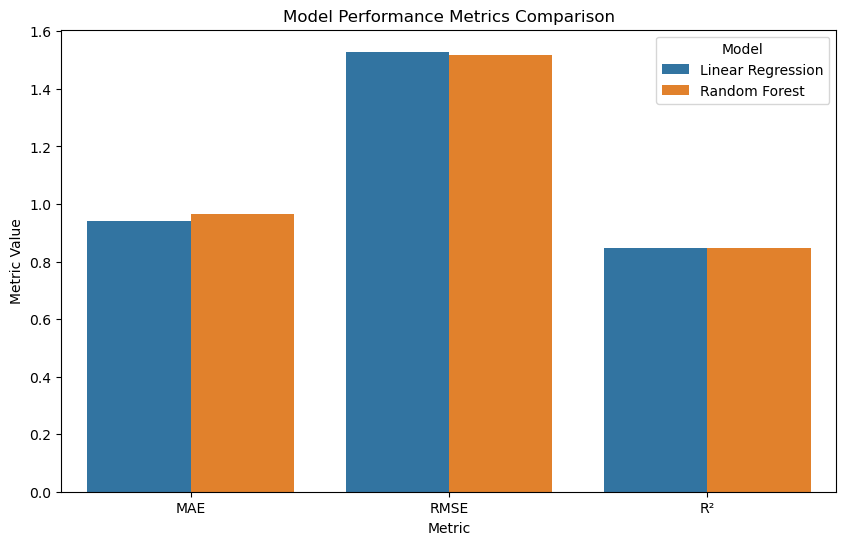

In [40]:
metrics = {
    'Metric': ['MAE', 'RMSE', 'R²'],
    'Linear Regression': [mae_lr, rmse_lr, r2_lr],
    'Random Forest': [mae_rf, rmse_rf, r2_rf]
}
metrics_df = pd.DataFrame(metrics).melt(id_vars='Metric', var_name='Model', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Model')
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Metric Value')
plt.show()


## 8. Conclusions
### **Key Findings**

Based on these findings, the key factors that most influence student performance are:

1. **Academic History**:  
   Prior grades (**G1** and **G2**) are the strongest predictors, indicating that a student's past academic performance is a crucial determinant of their final grades.

2. **Behavioral Factors**:  
   **Goout** (going out frequency) is also an important predictor, suggesting that students' extracurricular activities and social habits can impact their academic outcomes.

3. **Course-Specific Factors**:  
   The specific subject or course a student takes plays a significant role in their final grade, as indicated by the high coefficient for the **"subject"** feature.
  
#### Areas for future improvement:
- Consider adding more advanced models
- Perform feature selection
- Implement cross-validation
- Analyze interaction effects between variables